# Programming Assignment 2

In this assignment, you will:

1. Practice writing code to train and evaluate models using both the two-way holdout method, and an evaluation approach appropriate for models with hyperparameters that uses k-fold cross validation plus a test set.

2. Practice writing code to optimize a machine learning model. In particular, we will use gradient descent to optimize a logistic regression model.

3. **574 Only**: Perform optimization with a different algorithm (Newton-Raphson)

# Resources you can use to complete this assignment (a COMPLETE list)

**NOTE: You ARE allowed to use Google to find things that fit this list (i.e. it is often easy to google something like "plotly draw line graph" to find the right part of the plotly documentation).**

- Anything linked to in this article
- Anything linked to from the course web page
- Any materials from another online course taught at a university (**if you use this, you MUST provide a link to the exact document used**)
- Anything posted by Kenny, Navid, or Yincheng on Piazza



# Grading

For grading of code in Part 2, we will execute the submitted notebook as follows:

```shell
jupyter nbconvert --to python Assignment2-Student.ipynb
python Assignment2-Student.py
```

The PDF that comes along with this document has other details on the points awarded for each part.

As such, you will submit, one member of your group will subit as a zip file on UBLearns, a ```.zip``` file that contains 4 things:
- Your completed jupyter notebook.
- Your written report, answering all questions asked here (and copied in the assignment PDF)
- `part_1.1_results.csv`
- `part_1.4_results.csv`


# Part 1 - Predicting Review Scores on Pitchfork

For Part 1, we will be using data from [this paper](https://ojs.aaai.org/index.php/ICWSM/article/view/7355). The data is a collection of reviews from [Pitchfork](https://pitchfork.com/), a site that provides expert reviews of music album. The authors of this paper have also combined the data with a set of features from [Spotify’s API](https://developer.spotify.com/documentation/web-api/) that provide insight into the music itself, e.g. the "acousticness" of the song.  We will tackle a regression problem here, trying to predict the score of a review from several of the other columns in the dataset.

## Part 1.1 - Feature Engineering with Feature Subsets

In the first subsection of Part 1, we’re going to rely on our old friend linear regression. We’re going to look at how running linear regression with various subsets of our features impacts our ability to predict score.

In Part 1.1, your task is to write code below that trains a separate linear regression model for a number of different feature subsets.  Specifically:

- The list `feature_sets` below is a list of lists; each sublist is a different subset of features to build a model with. 
- All models should be trained on the dataset `part1_train.csv`. 
- For each of these trained models, you should evaluate the model’s predictions on the training dataset, as well as the provided test set, called `part1_test.csv`. The evaluation metric we will use is **root mean squared error**.  

Write out the result to a file called `part_1.1_results.csv` and submit this along with your assignment. The file should have the following columns:
- `feature_set` - a column describing the features of the model used. For feature sets with multiple features, combine them using an underscore (you can do this with the code `"_".join(feature_set)`)
- `training_rmse` - a column that gives the RMSE of a linear regression model trained on this feature set on the training data
- `test_rmse` - a column that gives the RMSE of a linear regression model trained on this feature set on the test data

In addition, please answer the following questions:
- **1.1.1** Which model had the best RMSE on the *training data*? 
- **1.1.2** Which model had the best RMSE on the *test data*? 
- **1.1.3** Which feature do you believe was the most important one? Why? *(Note: There is more than one perfectly acceptable way to answer this question)*
- **1.1.4** What can we say about the utility of the Spotify features based on these results?

In [473]:
feature_sets = [['artist'],
 ['reviewauthor'],
 ['releaseyear'],
 ['recordlabel'],
 ['genre'],
 ['danceability'],
 ['energy'],
 ['key'],
 ['loudness'],
 ['speechiness'],
 ['acousticness'],
 ['instrumentalness'],
 ['liveness'],
 ['valence'],
 ['tempo'],
 ['danceability','energy','key','loudness','speechiness','acousticness',
  'instrumentalness','liveness','valence','tempo'],
 ['artist', 'reviewauthor', 'releaseyear', 'recordlabel', 'genre'],
 ['artist', 'reviewauthor', 'releaseyear', 'recordlabel', 'genre', 'danceability', 
  'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',
  'liveness', 'valence', 'tempo']]


In [40]:
feature_sets1 = [['genre']]

In [81]:
def onehot_encode_var(data, varname, encoder):
    # This function should take in a variable name in part3_data and return a onehot encoded matrix for that variable
    
    # Use the encoder
    onehot_encoded_variable = encoder.fit_transform(data.loc[:,varname].values.reshape(-1, 1))
    
    # return the onehot encoded variable
    return onehot_encoded_variable, encoder.categories_

In [42]:
training_data['artist'].unique().shape

(106,)

In [43]:
test_data['artist'].unique().shape

(79,)

In [500]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder
# Write your code for Part 1.2 here
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Convenience things for you, note that releaseyear is continuous but is not a Spotify API variable
CONTINUOUS_FEATURES = ['releaseyear', 'danceability', 'energy', 'key', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo']
CATEGORICAL_FEATURES = ['artist', 'reviewauthor', 'recordlabel', 'genre']

result_data = []

for features in feature_sets:

    training_data = pd.read_csv("part1_train.csv")
    testing_data = pd.read_csv("part1_test.csv")
    
    training_data = training_data[features+['score']].dropna()
    testing_data = testing_data[features+['score']].dropna()
    
    train_data = training_data[features].copy()
    test_data = testing_data[features].copy()

    #maintain the list of continuous features that we really want
    l = []

    for feature in features:
        if feature in CATEGORICAL_FEATURES:
            train_encoder = OneHotEncoder(drop = 'if_binary', sparse = False)
            encoded_train_data, encoded_train_categories = onehot_encode_var(train_data, feature, train_encoder)

            test_encoder = OneHotEncoder(categories = list(encoded_train_categories), sparse = False, drop = 'if_binary')
            encoded_test_data, encoded_test_categories = onehot_encode_var(test_data, feature, test_encoder)

            train_data.loc[:, encoded_train_categories[0]] = encoded_train_data
            train_data.drop(feature, axis = 1, inplace=True);

            test_data.loc[:, encoded_test_categories[0]] = encoded_test_data
            test_data.drop(feature, axis = 1, inplace=True);

        if feature in CONTINUOUS_FEATURES:
            l.append(feature)
        
    if len(l) != 0:
        continuous_rescaled_X = StandardScaler().fit_transform(train_data[l].values)
        train_data[l] = continuous_rescaled_X
        continuous_rescaled_X = StandardScaler().fit_transform(test_data[l].values)
        test_data[l] = continuous_rescaled_X
    
    #train_data = train_data.reset_index(drop=True)
    #test_data = test_data.reset_index(drop=True)
    
    X = train_data
    y = training_data['score']
    X_test = test_data
    y_test = testing_data['score']
    ml = LinearRegression()
    ml.fit(X, y)
    
    print(features)
    
    y_predict = ml.predict(X_test)
    print("Test RMSE:",str(np.sqrt(np.sum((y_predict - y_test)*(y_predict - y_test))/y_test.shape[0])))
    
    y_train_predict = ml.predict(X)
    print("Train RMSE:",str(np.sqrt(np.sum((y_train_predict - y)*(y_train_predict - y))/y.shape[0])))
    
    print("\n")

['artist']
Test RMSE: 1.2435484147604263
Train RMSE: 1.2269866385722512


['reviewauthor']
Test RMSE: 1.1952864183375893
Train RMSE: 1.1812613825705123


['releaseyear']
Test RMSE: 1.2329724185986009
Train RMSE: 1.235994353048805


['recordlabel']
Test RMSE: 1.2350318325699403
Train RMSE: 1.205010717916833


['genre']
Test RMSE: 1.2420733739828465
Train RMSE: 1.2386020840752772


['danceability']
Test RMSE: 1.2411216679701793
Train RMSE: 1.2403624811168048


['energy']
Test RMSE: 1.23984587300203
Train RMSE: 1.2408996348511503


['key']
Test RMSE: 1.2438043904416536
Train RMSE: 1.243496923174606


['loudness']
Test RMSE: 1.2375610656577425
Train RMSE: 1.2369677308868912


['speechiness']
Test RMSE: 1.2435664640208375
Train RMSE: 1.2435303521321561


['acousticness']
Test RMSE: 1.2401107726711982
Train RMSE: 1.2403696602551413


['instrumentalness']
Test RMSE: 1.2388666922509561
Train RMSE: 1.2389894862716484


['liveness']
Test RMSE: 1.2435584958618833
Train RMSE: 1.243534386270501


[

## Part 1.2 - Feature Engineering with the LASSO

In Part 1.2, your task is to write code below that trains an L1-regularized linear regression model, with an expanded feature set.  Specifically:

1. Begin with the final feature set listed in `feature_sets` (i.e. your feature set, to begin this section, is `feature_sets[-1]`.
2. One-hot encode your categorical variables, setting `drop=if_binary` and `sparse=False` in the function arguments. 
3. Scale all of your continuous features using the `StandardScaler`.
4. Train an L1-regularized linear regression model using these features on the dataset `part1_train.csv`. You should use the [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html) class in `sklearn`, it will do the cross-validation necessary to select the appropriate value for the regularizer for you!  Use 10-fold cross-validation to perform model selection (set the `LassoCV` parmaeter `cv` to 10), and set the `random_state` to 1. Do not change any of the other parameters to `LassoCV` (i.e. leave them at their defaults).
5. Identify the best `alpha` value (the regularizer term, according to `sklearn`. In class, we refer to this as $\lambda$!) in terms of average mean squared error according to the cross-validation.
6. Finally, train a [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) model on the entire training dataset (`part1_train.csv`). You will use this to report the root mean squared error on the test set (Question 1.2.4 below), and use it in Part 1.3 below as well.

**Hint: The proceedure outlined above is very similar to ones we have discussed in class and shown how to do using `Pipeline`s.** 


In [452]:
# Write your code for Part 1.2 here
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler

training_data = pd.read_csv("part1_train.csv")
testing_data = pd.read_csv("part1_test.csv")
training_data = training_data[features+['score']].dropna()
testing_data = testing_data[features+['score']].dropna()

features = feature_sets[-1]
#features = ['artist']


train_data = training_data[features+['score']].dropna()
test_data = testing_data[features+['score']].dropna()

#maintain the list of continuous features that we really want
l = []

for feature in features:
    if feature in CATEGORICAL_FEATURES:
        train_encoder = OneHotEncoder(drop = 'if_binary', sparse = False)
        encoded_train_data, encoded_train_categories = onehot_encode_var(train_data, feature, train_encoder)
        
        test_encoder = OneHotEncoder(categories = list(encoded_train_categories), sparse = False, drop = 'if_binary')
        encoded_test_data, encoded_test_categories = onehot_encode_var(test_data, feature, test_encoder)
        
        train_data.loc[:, encoded_train_categories[0]] = encoded_train_data
        #for encoded_category in encoded_train_categories[0]:
        #    train_data.assign(encoded_train_category=encoded_train_data)
        train_data.drop(feature, axis = 1, inplace=True);
        
        test_data.loc[:, encoded_test_categories[0]] = encoded_test_data
        test_data.drop(feature, axis = 1, inplace=True);
        
    if feature in CONTINUOUS_FEATURES:
        l.append(feature)
continuous_rescaled_X = StandardScaler().fit_transform(train_data[l].values)
train_data[l] = continuous_rescaled_X
continuous_rescaled_X = StandardScaler().fit_transform(test_data[l].values)
test_data[l] = continuous_rescaled_X

In [453]:
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [454]:
X = train_data
y = training_data['score']
X_test = test_data
y_test = testing_data['score']
lasso_cv_model = LassoCV(cv = 10, random_state = 1)
lasso_cv_model.fit(X, y)

LassoCV(cv=10, random_state=1)

In [455]:
lasso_cv_model.score(X_test, y_test)

0.9999989998281829

In [456]:
lasso_cv_model.alpha_

0.0015566700407125167

In [457]:
print("1.2. What was the average RMSE of the model with this alpha value on the k-fold cross validation on the training data? \nAns:" + str(np.mean(lasso_cv_model.mse_path_[np.where(lasso_cv_model.alphas_ == lasso_cv_model.alpha_)[0][0]])))

1.2. What was the average RMSE of the model with this alpha value on the k-fold cross validation on the training data? 
Ans:1.557311406495256e-06


In [458]:
lasso_model = Lasso(alpha=lasso_cv_model.alpha_)

In [459]:
lasso_model.fit(X, y)

Lasso(alpha=0.0015566700407125167)

In [460]:
lasso_model.score(X_test, y_test)

0.9999989998281829

In [461]:
y_predict = lasso_model.predict(X_test)

In [462]:
print("1.2.4  RMSE with Lasso regression with the best alpha on the test data " + str(np.sqrt(np.sum((y_predict - y_test)*(y_predict - y_test))/y_test.shape[0])))

1.2.4  RMSE with Lasso regression with the best alpha on the test data 0.0012519252204333154


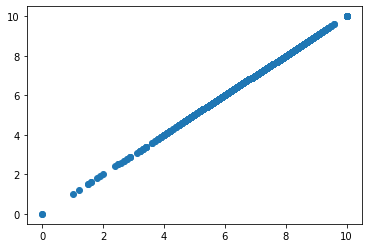

In [463]:
import matplotlib.pyplot as plt
plt.scatter(x=y_test, y=y_predict)

Now, answer the following questions:
- **1.2.1** - How many total features are introduced by Step 2 above? Provide both the number and an explanation of how you got to this number.
- **1.2.2** - What was the best `alpha` value according to your cross-validation results?
- **1.2.3** - What was the **average RMSE** of the model with this `alpha` value on the k-fold cross validation on the *training* data?
- **1.2.4** - What was the **RMSE** of the model with this `alpha` value on the k-fold cross validation on the *test* data?


# Part 1.3 - Interpreting Model Coefficents

In this section we will interpret the coefficients from the final model you trained on all of the training data.

- **1.3.1** - How many non-zero coefficients are in this final model?
- **1.3.2** - What percentage of the coefficients are non-zero in this final model?
- **1.3.3** - Who were the three most critical review authors, as estimated by the model? How do you know?
- **1.3.4** - Who were the three artists that reviewers tended to like the most?  How do you know?
- **1.3.5** - What genre did Pitchfork reviewers tend to like the most? Which genre did they like the least?


In [278]:
print("1.3.1 - How many non-zero coefficients are in this final model?\nAns:" + str((lasso_model.coef_!=0).sum()))

1.3.1 - How many non-zero coefficients are in this final model?
Ans:497


In [284]:
print("1.3.2 - What percentage of the coefficients are non-zero in this final model?\nAns:" + str((lasso_model.coef_!=0).sum()*100/lasso_model.coef_.shape[0]))

1.3.2 - What percentage of the coefficients are non-zero in this final model?
Ans:72.55474452554745


In [355]:
coefs = pd.DataFrame(
    lasso_model.coef_,
    columns=["Coefficients"],
    index=X.columns,
)

coefs.sort_values(by="Coefficients", inplace=True)

In [356]:
tmp = []
for x in coefs.index:
    if x in training_data.reviewauthor.unique():
        tmp.append(x)

In [357]:
print("1.3.3 - Who were the three most critical review authors, as estimated by the model? How do you know?\nAns:" + str(tmp[-3:]))

1.3.3 - Who were the three most critical review authors, as estimated by the model? How do you know?
Ans:['Jenn Pelly', 'kris ex', 'Judy Berman']


In [358]:
tmp = []
for x in coefs.index:
    if x in training_data.artist.unique():
        tmp.append(x)

In [359]:
print("1.3.4 - Who were the three artists that reviewers tended to like the most? How do you know?\nAns:" + str(tmp[-3:]))

1.3.4 - Who were the three artists that reviewers tended to like the most? How do you know?
Ans:['Nick Cave & the Bad Seeds', 'Miles Davis', 'R.E.M.']


In [360]:
tmp = []
for x in coefs.index:
    if x in training_data.genre.unique():
        tmp.append(x)
print("1.3.5 - What genre did Pitchfork reviewers tend to like the most? Which genre did they like the least?\nAns:" + str(tmp[-3:]) + "\n" + str(tmp[0]))

1.3.5 - What genre did Pitchfork reviewers tend to like the most? Which genre did they like the least?
Ans:['none', 'Jazz', 'Global']
Electronic


# Part 1.4 - "Manual" Cross-Validation + Holdout for Model Selection and Evaluation

We will finally use cross validation for both algorithm and model selection, with a hold-out test set for a final evaluation. We will use **5-fold cross validation** to identify the best parameters and hyperparameters for a set of models. We will then take our final models and use a final hold-out test set (the same one as above) to estimate the generalization error of the models.

Specifically, your task is first to write code that trains and evaluates the following models, one for each of the specified hyper parameters sets:

- `Decision Tree regression` - All combinations of a `max_depth` of 5, 10, or 20, and a `criterion` of `"squared error"` or `"absolute error"`. Use the [DecisionTreeRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor).
- Ridge regression - Use the following choices of L2 penalty: $[10^{-5}, 10^{-4}, ..., 10^4, 10^5]$. In Python, you can create a list of these numbers using `np.logspace(-5, 5, 11)`. Use the [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) class from sklearn to train a Ridge Regression model. The parameters you need to pass when constructing the Ridge model are `alpha`, which lets you specify what you want the L2 penalty to be, and `random_state=0` to avoid randomness.
- kNN regression - Values of `n_neighbors` of 1, 5, 10, and 15. Use the [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) class.

Additional notes:
1. All models should use the feature sets described in Part 1.3 (the same ...one-hot encoded... categorical variables, and the scaled continuous variables)
2. As opposed to using the `KFold` class from `sklearn` like we did in class, we have instead provided you with pre-existing data sets; you should therefore use the pre-split data in the provided CSV files ``1.2_fold0.csv ... 1.2_fold4.csv``

**What to submit**:

1. Write out the result to a file called `part_1.4_results.csv` and submit this along with your assignment. The file should have the following columns:
- `model_name` - The name of the model, one of `DTR` (Decision Tree Regression), `Ridge`, or `KNN`.
- `hyperparameter_setting` - a column describing the hyperparameters of the model. For models with multiple hyperparameters, combine them using an underscore (you can do this with the code `"_".join(hyperparameters)`).
- `mean_training_rmse` - a column that gives the mean RMSE on the k-fold training data. You should take the average of the model’s errors on the different folds, using root mean squared error again as your evaluation metric.
- `sd_training_rmse` - a column that gives the standard deviation RMSE on the k-fold training data.
- `test_rmse` - a column that gives the RMSE of a linear regression model trained on this feature set on the test data


2. Answer the following questions:
- **1.4.1** Report, for each model, the hyper parameter setting that resulted in the best performance
- **1.4.2** Which model performed the best overall on the cross-validation? 
- **1.4.3** Which model performed the best overall on the final test set? 
- **1.4.4** With respect to your answer for 1.4.3, why do you think that might be? (*Note: there is more than one correct way to answer this question*)
- **1.4.5** Which model/hyperparameter setting had the highest standard deviation across the different folds of the cross validation?
- **1.4.6** With respect to your answer for 1.4.6, why do you think that might be? (*Note: there is more than one correct way to answer this question*)

In [365]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
DecisionTreeRegressor()

In [366]:
hyper_params = {"DTR":[5, 10, 20], "Ridge":np.logspace(-5, 5, 11), "knn":[1, 5, 10, 15]}

In [448]:
def preprocess(tr_data, tst_data, vl_data, features):
    #maintain the list of continuous features that we really want
    l = []

    for feature in features:
        if feature in CATEGORICAL_FEATURES:
            train_encoder = OneHotEncoder(drop = 'if_binary', sparse = False, handle_unknown='error')
            encoded_train_data, encoded_train_categories = onehot_encode_var(tr_data, feature, train_encoder)

            test_encoder = OneHotEncoder(categories = list(encoded_train_categories), sparse = False, drop = 'if_binary')
            encoded_test_data, encoded_test_categories = onehot_encode_var(tst_data, feature, test_encoder)
            
            val_encoder = OneHotEncoder(categories = list(encoded_train_categories), sparse = False, drop = 'if_binary')
            encoded_vl_data, encoded_vl_categories = onehot_encode_var(vl_data, feature, val_encoder)

            tr_data.loc[:, encoded_train_categories[0]] = encoded_train_data
            tr_data.drop(feature, axis = 1, inplace=True);

            tst_data.loc[:, encoded_test_categories[0]] = encoded_test_data
            tst_data.drop(feature, axis = 1, inplace=True);
            
            vl_data.loc[:, encoded_vl_categories[0]] = encoded_vl_data
            vl_data.drop(feature, axis = 1, inplace=True);

        if feature in CONTINUOUS_FEATURES:
            l.append(feature)
    continuous_rescaled_X = StandardScaler().fit_transform(tr_data[l].values)
    tr_data[l] = continuous_rescaled_X
    continuous_rescaled_X = StandardScaler().fit_transform(tst_data[l].values)
    tst_data[l] = continuous_rescaled_X
    continuous_rescaled_X = StandardScaler().fit_transform(vl_data[l].values)
    vl_data[l] = continuous_rescaled_X
    return tr_data, tst_data, vl_data

In [470]:
fname = "1.2_fold"
testing_data = pd.read_csv("part1_test.csv")
testing_data = testing_data[features+['score']].dropna()
res = {}

for model in hyper_params:
    
    hyper = []
    train_err = []
    test_err = []
    val_err = []
    
    if model == "Ridge":
        print("\n===Model:Ridge===\n")
        for l2 in hyper_params[model]:
            reg = Ridge(random_state = 0, alpha=l2)
            
            for val in range(5):
                for cv in range(5):
                    if val == cv:
                        val_data = pd.read_csv(fname+str(cv)+".csv")
                        continue
                    d = pd.read_csv(fname+str(cv)+".csv")
                    if train_data.empty:
                        train_data = d
                    else:
                        train_data = train_data.append(d)
                
                testing_data = pd.read_csv("part1_test.csv")
                
                features = feature_sets[-1]
                train_data = train_data[features+['score']].dropna()
                val_data = val_data[features+['score']].dropna()
                testing_data = testing_data[features+['score']].dropna()
                
                y_tr = train_data['score']
                y_vl = val_data['score']
                y_tst = testing_data['score']
                
                tr_data, tst_data, vl_data = preprocess(train_data, testing_data, val_data, features)
                X_tr = tr_data
                X_vl = vl_data
                X_tst = tst_data
                
                print("======\n Config: \n=======\ncv:"+ str(val) +" l2:" + str(l2))
                reg.fit(X_tr, y_tr)
                
                tr_predict = reg.predict(X_tr)
                print("Train RMSE:" + str(np.sqrt(np.sum((tr_predict - y_tr)*(tr_predict - y_tr))/tr_predict.shape[0])))
                      
                vl_predict = reg.predict(X_vl)
                print("Val RMSE:" + str(np.sqrt(np.sum((vl_predict - y_vl)*(vl_predict - y_vl))/vl_predict.shape[0])))
                      
                tst_predict = reg.predict(X_tst)
                print("Test RMSE:" + str(np.sqrt(np.sum((tst_predict - y_tst)*(tst_predict - y_tst))/tst_predict.shape[0])))
                
                hyper.append(l2)
                train_err.append(np.sum((tr_predict - y_tr)*(tr_predict - y_tr)))
                test_err.append(np.sum((tst_predict - y_tst)*(tst_predict - y_tst)))
                val_err.append(np.sum((vl_predict - y_vl)*(vl_predict - y_vl)))
                
        if model == "DTR":
            print("\n===Model:DTR===\n")
            for mx_depth in hyper_params[model]:
                reg = DecisionTreeRegressor(max_depth = mx_depth)

                for val in range(5):
                    for cv in range(5):
                        if val == cv:
                            val_data = pd.read_csv(fname+str(cv)+".csv")
                            continue
                        d = pd.read_csv(fname+str(cv)+".csv")
                        if train_data.empty:
                            train_data = d
                        else:
                            train_data = train_data.append(d)

                    testing_data = pd.read_csv("part1_test.csv")

                    features = feature_sets[-1]
                    train_data = train_data[features+['score']].dropna()
                    val_data = val_data[features+['score']].dropna()
                    testing_data = testing_data[features+['score']].dropna()

                    y_tr = train_data['score']
                    y_vl = val_data['score']
                    y_tst = testing_data['score']

                    tr_data, tst_data, vl_data = preprocess(train_data, testing_data, val_data, features)
                    X_tr = tr_data
                    X_vl = vl_data
                    X_tst = tst_data

                    print("======\n Config: \n=======\ncv:"+ str(val) +" max_dpeth:" + str(mx_depth))
                    reg.fit(X_tr, y_tr)

                    
                    tr_predict = reg.predict(X_tr)
                    print("Train RMSE:" + str(np.sqrt(np.sum((tr_predict - y_tr)*(tr_predict - y_tr))/tr_predict.shape[0])))

                    vl_predict = reg.predict(X_vl)
                    print("Val RMSE:" + str(np.sqrt(np.sum((vl_predict - y_vl)*(vl_predict - y_vl))/vl_predict.shape[0])))

                    tst_predict = reg.predict(X_tst)
                    print("Test RMSE:" + str(np.sqrt(np.sum((tst_predict - y_tst)*(tst_predict - y_tst))/tst_predict.shape[0])))
                    
                    hyper.append(mx_depth)
                    train_err.append(np.sum((tr_predict - y_tr)*(tr_predict - y_tr)))
                    test_err.append(np.sum((tst_predict - y_tst)*(tst_predict - y_tst)))
                    val_err.append(np.sum((vl_predict - y_vl)*(vl_predict - y_vl)))
                    
        if model == "KNN":
            print("\n===Model:KNN===\n")
            for k in hyper_params[model]:
                reg = KNeighborsRegressor(n_neighbors=k)

                for val in range(5):
                    for cv in range(5):
                        if val == cv:
                            val_data = pd.read_csv(fname+str(cv)+".csv")
                            continue
                        d = pd.read_csv(fname+str(cv)+".csv")
                        if train_data.empty:
                            train_data = d
                        else:
                            train_data = train_data.append(d)

                    testing_data = pd.read_csv("part1_test.csv")

                    features = feature_sets[-1]
                    train_data = train_data[features+['score']].dropna()
                    val_data = val_data[features+['score']].dropna()
                    testing_data = testing_data[features+['score']].dropna()

                    y_tr = train_data['score']
                    y_vl = val_data['score']
                    y_tst = testing_data['score']

                    tr_data, tst_data, vl_data = preprocess(train_data, testing_data, val_data, features)
                    X_tr = tr_data
                    X_vl = vl_data
                    X_tst = tst_data

                    print("======\n Config: \n=======\ncv:"+ str(val) +" k neighbor:" + str(k))
                    reg.fit(X_tr, y_tr)

                    
                    tr_predict = reg.predict(X_tr)
                    print("Train RMSE:" + str(np.sqrt(np.sum((tr_predict - y_tr)*(tr_predict - y_tr))/tr_predict.shape[0])))

                    vl_predict = reg.predict(X_vl)
                    print("Val RMSE:" + str(np.sqrt(np.sum((vl_predict - y_vl)*(vl_predict - y_vl))/vl_predict.shape[0])))

                    tst_predict = reg.predict(X_tst)
                    print("Test RMSE:" + str(np.sqrt(np.sum((tst_predict - y_tst)*(tst_predict - y_tst))/tst_predict.shape[0])))

                    hyper.append(k)
                    train_err.append(np.sum((tr_predict - y_tr)*(tr_predict - y_tr)))
                    test_err.append(np.sum((tst_predict - y_tst)*(tst_predict - y_tst)))
                    val_err.append(np.sum((vl_predict - y_vl)*(vl_predict - y_vl)))
        res[model] ={'hyper_params' : hyper, 'train_rmse' : train_err, 'test_rmse' : test_err, 'val_rmse' : val_err} 


===Model:Ridge===

 Config: 
cv:0 l2:1e-05
Train RMSE:7.405561151663005e-10
Val RMSE:7.724358370182496e-10
Test RMSE:7.860462438904194e-10
 Config: 
cv:1 l2:1e-05
Train RMSE:7.390434923228358e-10
Val RMSE:7.571217792133875e-10
Test RMSE:7.863021366974671e-10
 Config: 
cv:2 l2:1e-05
Train RMSE:7.543104339308064e-10
Val RMSE:8.423494734273789e-10
Test RMSE:8.141996653005762e-10
 Config: 
cv:3 l2:1e-05
Train RMSE:7.434910656862526e-10
Val RMSE:7.957749585925282e-10
Test RMSE:7.952381919428956e-10
 Config: 
cv:4 l2:1e-05
Train RMSE:7.427160940008355e-10
Val RMSE:7.728334049242395e-10
Test RMSE:7.893483460269602e-10
 Config: 
cv:0 l2:0.0001
Train RMSE:7.405537779186079e-09
Val RMSE:7.72432966372952e-09
Test RMSE:7.860432117738934e-09
 Config: 
cv:1 l2:0.0001
Train RMSE:7.390390825911463e-09
Val RMSE:7.571171336192666e-09
Test RMSE:7.862971426147447e-09
 Config: 
cv:2 l2:0.0001
Train RMSE:7.543085576476027e-09
Val RMSE:8.423470896885893e-09
Test RMSE:8.141972033669201e-09
 Config: 
cv:3 l2:

# Part 2

In class, we have shifted from regression to classification. Here, we're going to get a little practice in optimizing one of the classification models we saw in class - logistic regression. As a reminder...

The loss function of logistic regression (also known as the logistic-loss or log-loss) is given by:
\begin{equation}
  J({\bf w}) = \frac{1}{n}\sum_{i=1}^n \log{(1 + \exp{(-y_i{\bf w}^\top{\bf x}_i}))}
  \label{eqn:logloss}
\end{equation}

The gradient for this loss function, as derived in class, is:
\begin{equation}
  \nabla J({\bf w}) = -\frac{1}{n}\sum_{i=1}^n \frac{y_i}{1 + \exp{(y_i{\bf w}^\top{\bf x}_i)}}{\bf x}_i
  \label{eqn:loglossgradient}
\end{equation}


The Hessian for the loss function is given by:
\begin{equation}
  {\bf H}({\bf w}) = \frac{1}{n} \sum_{i=1}^n \frac{\exp{(y_i{\bf w}^\top{\bf x}_i)}}{(1 + \exp{(y_i{\bf w}^\top{\bf x}_i)})^2}{\bf x}_i{\bf x}_i^\top
  \label{eqn:loglosshessian}
\end{equation}

## Part 2.1 - Logistic Regression with Gradient Descent

In Part 2.1 we will implement logistic regression with gradient descent. You need to finish implementing 3 functions:

1. `logistic_objective` - compute the logistic loss for the given data set (see equation above)
2. `logistic_gradient` - compute the gradient vector of logistic loss for the given data set (see equation above)
3. `run_gradient_descent` - run the gradient descent algorithm, given these two functions.

We have provided you with some simulation data to evaluate your method with. Part 2.1 will, however, largely be graded by evaluating your code on a slightly different dataset to ensure robustness. 

In addition, please submit answers to the following questions on your written report:

- **2.1.1** - How did you go about selecting a good step size, i.e. one that was not too big or too small? (*Note: There is more than one correct answer to this*)
- **2.1.2** - What is the condition under which we assume that the gradient descent algorithm has converged in the code here?
- **2.1.3** - What is a different convergence metric we could have used? (*Note: There is more than one correct answer to this*)

In [7]:
def logistic_objective(w, X, y):

    # compute log-loss error (scalar) with respect
    # to w (vector) for the given data X and y                               
    # Inputs:
    # w = d x 1
    # X = N x d
    # y = N x 1
    # Output:
    # error = scalar
    
    # IMPLEMENT THIS METHOD - REMOVE THE NEXT LINE
    error = 0
    return error

def logistic_gradient(w, X, y):

    # compute the gradient of the log-loss error (vector) with respect
    # to w (vector) for the given data X and y  
    #
    # Inputs:
    # w = d x 1
    # X = N x d
    # y = N x 1
    # Output:
    # error = d length gradient vector (not a d x 1 matrix)

    # IMPLEMENT THIS METHOD - REMOVE THE NEXT LINE
    gradient = 0
    return gradient

def run_gradient_descent(X,y):
    old_w = np.array([-1]*X.shape[1])
    # change this value! This is an unreasonable step size
    step_size = 10000
    new_w =old_w - 1
    
    while ((new_w-old_w)**2).sum() > .0000000001:
        #IMPLEMENT THIS!
        pass
    return new_w



In [8]:
from scipy.stats import uniform, bernoulli
import functools
draw_binary = functools.partial(np.random.binomial,n=1)

## Simulated data to test your method
DATA_SIZE = 10000
x1 = bernoulli(.5).rvs(DATA_SIZE)
x2 = np.floor(uniform(18,60).rvs(DATA_SIZE))
true_w = [-9, 3.5, 0.2]
xb = true_w[0] + true_w[1]*x1 + true_w[2]*x2
p = 1/(1 + np.exp(-xb))
y = np.array([1 if draw_binary(p=v) else -1 for v in p])

In [9]:
from sklearn.linear_model import LogisticRegression

# notice that logistic regression as implemented in sklearn does not get the exact results either!
# so you shouldn't worry if you're a bit off
X = np.hstack([np.ones((len(xb),1)), x1[:,np.newaxis], x2[:,np.newaxis]])
model = LogisticRegression(solver='liblinear', random_state=0,fit_intercept=False)
model.fit(X,y).coef_

array([[-8.58020492,  3.40771205,  0.19037032]])

In [ ]:
# this is how we will test your results
gd_result = run_gradient_descent(X,y)
# is your result relatively close to the truth?
np.abs(true_w-gd_result).sum()

## <span style="color:red"> 574 Only</span> Part 2.2 - Optimization with Newton-Raphson <span style="color:red"> 574 Only</span>

In Part 2.2, you are going to, instead of using gradient descent, use the Newton-Raphson method to optimize the same logistic regression model. To do so, you will need to 1) implement the `logistic_hessian` function to compute the Hessian matrix of logistic loss for the given data set, and 2) use `scipy`'s `optimize` function to perform the optimization, rather than writing a function by hand to do so.  

For Part 2.2, you will only need to implement these functions, we will test them using our own code. You can, however, perform the same kinds of tests that we proposed above to check your work! 

In [ ]:
def logistic_hessian(w, X, y):

    # compute the Hessian of the log-loss error (matrix) with respect
    # to w (vector) for the given data X and y                               
    #
    # Inputs:
    # w = d x 1
    # X = N x d
    # y = N x 1
    # Output:
    # Hessian = d x d matrix
    
    
    if len(w.shape) == 1:
        w = w[:,np.newaxis]

    # IMPLEMENT THIS METHOD - REMOVE THE NEXT LINE
    hessian = 0
    return hessian

In [ ]:
from scipy.optimize import minimize

def run_newton_raphson(X,y):
    args = (X,y[:,np.newaxis])
    opts = {'maxiter' : 50}    # Preferred value.    
    w_init = np.zeros(X.shape[1])
    
    # note: this is *almost* what you need, you just need to figure out what arguments are necessary here!
    soln = minimize(PUT_THE_RIGHT_ARGUMENTS_IN_HERE!
                    args=args,
                    method='Newton-CG',
                    options=opts)

    w = np.transpose(np.array(soln.x))
    w = w[:,np.newaxis]
    return w


In [ ]:
run_newton_raphson(X,y)